In [28]:
# Making non-stationary time series stationary
import cpi
import pandas as pd
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import yfinance as yf
import matplotlib.pyplot as plt

In [11]:
df = yf.download('GC=F', start = '2000-01-01',
                end='2020-01-01',
                progress=True)
df.rename(columns = {'Close': 'price'}, inplace = True)
df = df.resample('M').last()
df = df[['price']]

[*********************100%***********************]  1 of 1 completed


In [5]:
cpi.update()

In [8]:
# Define a function for running the ADF test

def adf_test(x):
    indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag = 'AIC')
    results = pd.Series(adf_test[:4], index = indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    return results
        

In [26]:
# run the test

adf_test(df)
# the null hypothesis : ts is not stationary
# p-values is more then Critical Value (1%) that's why we fail to reject the null hypothesis 

Test Statistic             -1.245430
p-value                     0.653754
# of Lags Used             11.000000
# of Observations Used    221.000000
Critical Value (1%)        -3.460291
Critical Value (5%)        -2.874709
Critical Value (10%)       -2.573789
dtype: float64

In [24]:
# since the test statistic  > critical value 1% we conclude that ts is not stationary

def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression = h0_type)
    
    results = pd.Series(kpss_test[:3], index = indices)
    print()
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results
        
    

In [27]:
kpss_test(df)
# the null hypothesis : ts is stationary
# p-values is less then Critical Value (1%) that's why we reject the null hypothesis 

/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/anna/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic            1.253341
p-value                   0.010000
# of Lags                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

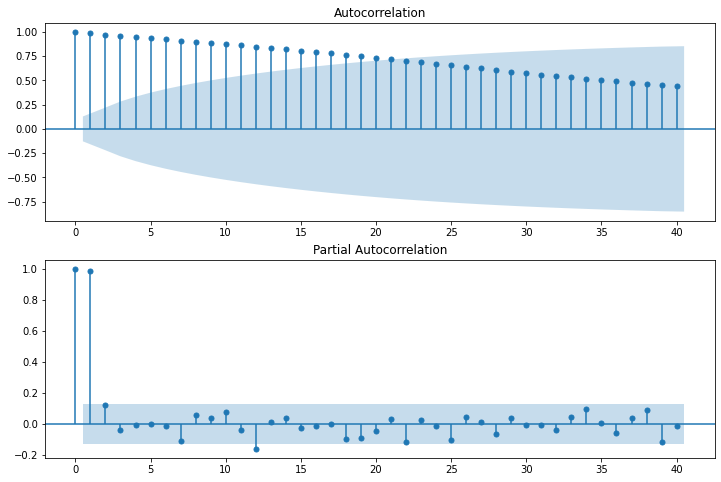

In [33]:
# Generate the ACF/PACF plots

N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1, figsize = (12, 8))
plot_acf(df.price, ax = ax[0], lags = N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.price, ax= ax[1], lags = N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.show()